In [153]:
import importlib

from PIL import Image

import numpy as np

from noisyopt import minimizeCompass

from sortedcontainers import SortedList

import pandas as pd

import matplotlib.pyplot as plt


import matplotlib.cbook as cbook
from matplotlib.pylab import rcParams
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

from skimage.feature import peak_local_max
from skimage.segmentation import watershed

from scipy import ndimage as ndi

plt.rcParams["figure.figsize"] = (6.0*1.5,5.2*1.5)

In [154]:
from skimage import data

from skimage.util import img_as_ubyte

orig_phantom = img_as_ubyte(data.shepp_logan_phantom())

from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk  # noqa

footprint = disk(3)
footprint = np.ones((2,2))


In [155]:
import importlib

import positioning_sensors as ps
importlib.reload(ps)

<module 'positioning_sensors' from '/Users/rodrigo/SourceCodes/git/optimal_light_sensor_location/positioning_sensors.py'>

Carga de Imágenes

In [156]:
#Original nocturnal image without values <21
im1 = np.array(Image.open('example/inputs/qro_light_th'))
im1 = np.where(im1==255, 0, im1) 

#Region priorities of Jorge and Lamphar
P = np.array(Image.open('example/inputs/prioridades'))

#calcular este valor automaticamente
nc = 5

# 0 máxima prioridad
# 4 mínima prioridad (antes espacio nan)
P = np.where(np.isnan(P),nc, P)-1 
P = P.max()-P


im1_gr = ps.filtro_fuerza_puntual(im1,h=3,e=4)

W1 = ps.f5(im1,P)
W2 = ps.f5(im1_gr,P)

In [157]:
th = 62
image = im1>=th
distance = ndi.distance_transform_edt(image)


nons = (im1>=th)*im1

nonsat = im1+(distance*2)


Transformada de la distancia en la región saturada. Usamos esta en vez de la transformación que nos inventamos

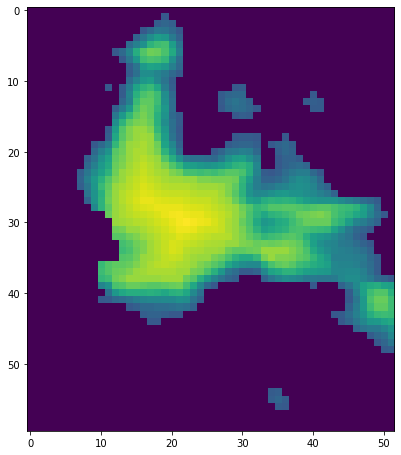

In [158]:
plt.imshow(nonsat)
plt.show()

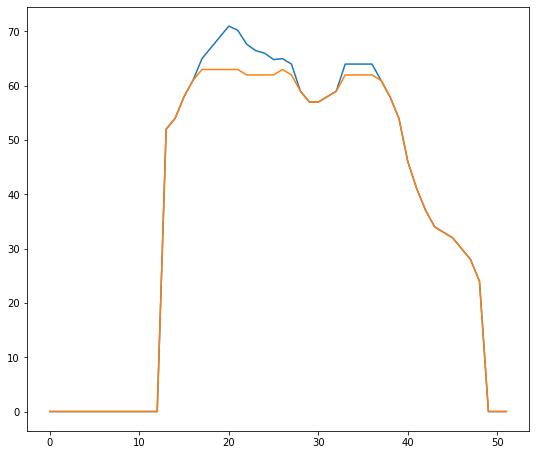

In [159]:
# Ejemplo Sección desaturada vs original saturada fila 34

plt.plot(nonsat[34,:])
plt.plot(im1[34,:])

In [160]:
atol = 30
rs=30
th = 0.0025
setC = np.zeros(nonsat.shape)
f = 1

In [161]:
#seeds = ps.getMax(nonsat,P)
seeds = ps.getMax(nonsat)
coords = ps.get_coords(seeds)

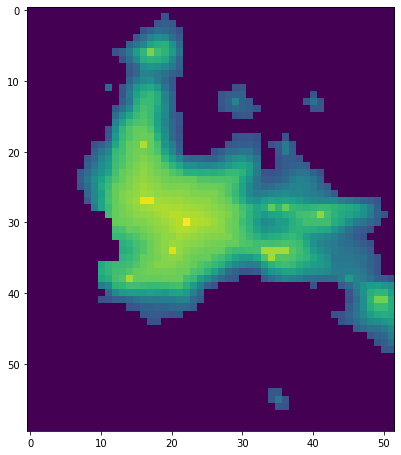

In [162]:
plt.imshow(seeds+nonsat)

In [163]:
footprint = disk(2)
atol = 30
rs=30
th = 0.003
setC = np.zeros(nonsat.shape)
f = 1

z = np.zeros((len(coords[1:]),nonsat.shape[0],nonsat.shape[1]))


for i,c in enumerate(coords[1:]):
    
    print(c)
    setC = np.zeros(nonsat.shape)
    dy = c[0]
    dx = c[1]
 #   setC[dy,dx]=2
    for direction in range(0,359,2):
        
        setA = np.zeros(nonsat.shape)
        setB = np.zeros(nonsat.shape)

        gm1 = direction-atol
        gm2 = direction+atol
        
        m1 = np.tan(np.radians(gm1))
        m2 = np.tan(np.radians(gm2))
#        mc = np.tan(np.radians(gm2))

        for y in range(nonsat.shape[0]):
            for x in range(nonsat.shape[1]):
                
                #if angle is in right or left side
                if gm1<90 or gm1>90*3:
                    setA[y][x] = 1 if m1*(x-dx)+dy-y <0 else 0
                else:
                    setA[y][x] = 0 if m1*(x-dx)+dy-y <0 else 1

                if gm2<90 or gm2>90*3:
                    setB[y][x] = 0 if m2*(x-dx)+dy-y <0 else 1
                else:
                    setB[y][x] = 1 if m2*(x-dx)+dy-y < 0 else 0

        mask = setA*setB
        p = np.array([dy,dx])
        sc = ps.makeSpatialScatter(p,mask,nonsat)
        variogram = ps.variogram(sc)
    
        variogram_th = variogram < 30
        
        radio  = 0 if variogram_th[0]==False else np.sum(variogram_th[:np.where((variogram_th)==False)[0][0]])
        
        
        radio = 100
        for r in np.arange(0,radio,0.1):
    
            # h = internal angle*sin(angle)
            y = np.int(np.round(r*np.sin(np.radians(direction))))
            x = np.int(np.round(r*np.cos(np.radians(direction))))
            
#            if x !=0 or y!=0:
#                print((r*np.sin(np.radians(direction))),(r*np.cos(np.radians(direction))))
   
                
         #   print(x,y)
            #we take care of the squared boundaries
            py = nonsat.shape[0]-1 if dy+y>=nonsat.shape[0] else dy+y
            px = nonsat.shape[1]-1 if dx+x>=nonsat.shape[1] else dx+x
            
         #   print(px,py)
            #setC[py,px]=f
            if ((dy+y)<=nonsat.shape[0]) or ((dx+x)>=nonsat.shape[1]):
                r_int = int(np.round(r))
                setC[py,px]=variogram[r_int]
 

    setC[dy,dx] = 1000
    z[i]=setC
    plt.imshow(nonsat+setC*100)
    
    plt.show()
    
    

[ 6 17]


IndexError: index 29 is out of bounds for axis 0 with size 29

In [164]:
a = np.array([0, 20, 0, 0])



In [165]:
np.where((a<1)==False)[0][0]


1

In [166]:
phantom = orig_phantom.copy()
phantom[10:30, 200:210] = 0

closed = closing(setC, footprint)
#plot_comparison(phantom, closed, 'closing')

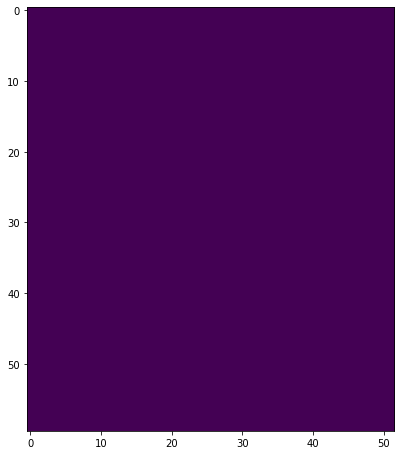

In [167]:
plt.imshow(z[1])

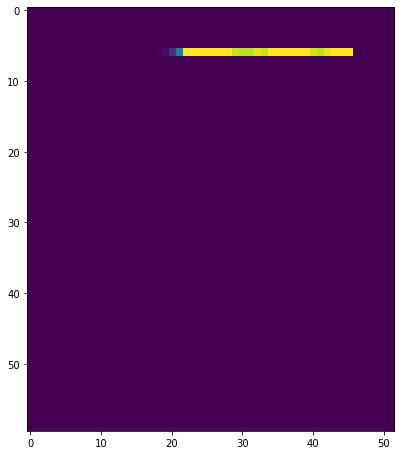

In [168]:
plt.imshow(nonsat+setC*100)

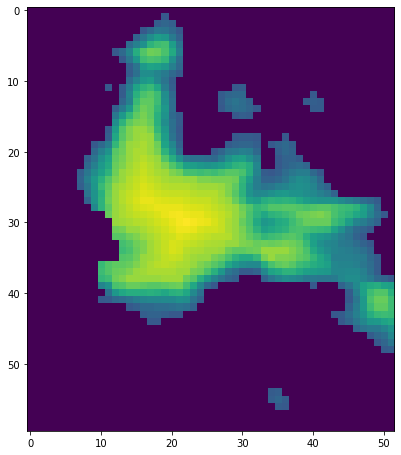

In [169]:
A = [nonsat,nonsat]
plt.imshow(A[1])

In [175]:
mask = np.zeros(im1.shape, dtype=bool)
mask[tuple(coords.T)] = True

markers, _ = ndi.label(mask)
labels = watershed(-nonsat, markers, mask=im1)

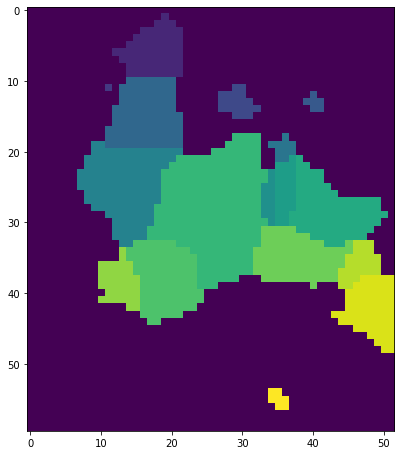

In [176]:
plt.imshow(labels)

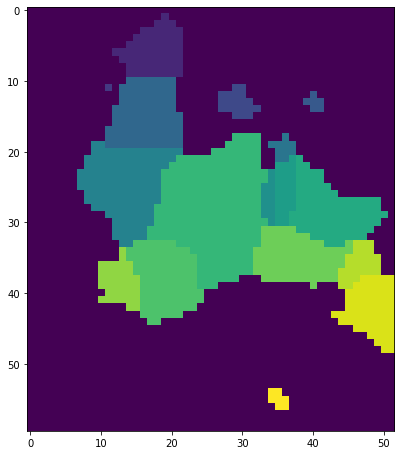

In [177]:
labels

plt.imshow(labels)

In [186]:
from numpy import asarray
from numpy import savetxt

In [188]:
zws = np.zeros(( len(coords[1:]),labels.shape[0],labels.shape[1])) 

for i, c in enumerate(coords[1:]):
    zws[i] = labels==labels[c[0],c[1]]
    savetxt("variograms/data_waterse=hed_{n}.csv".format(n=str(i)),zws[i],delimiter=",")
    
    
    
len(coords)

25

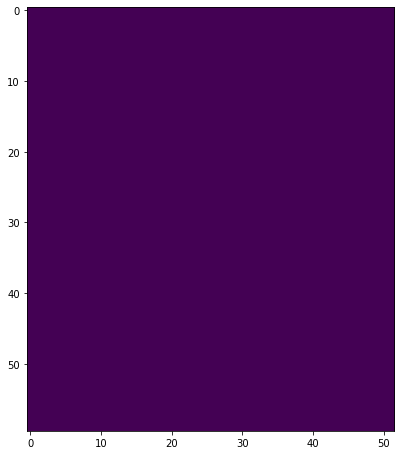

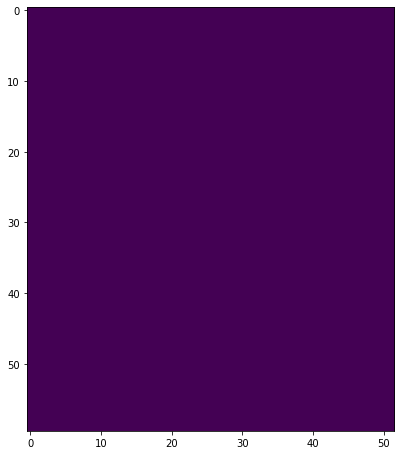

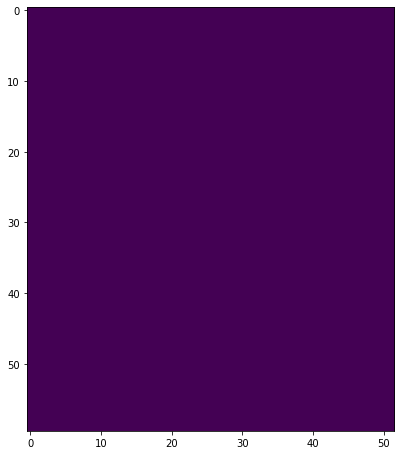

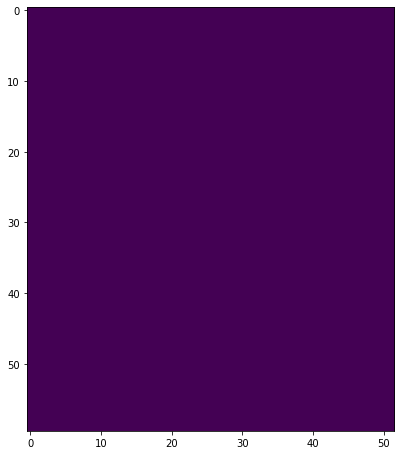

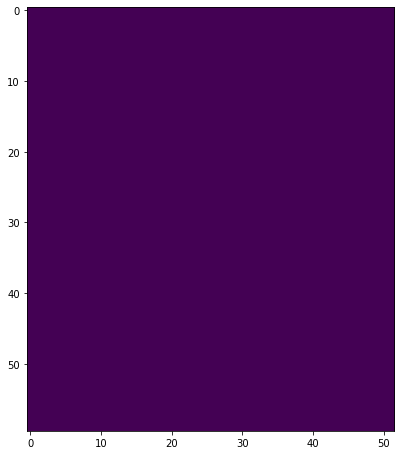

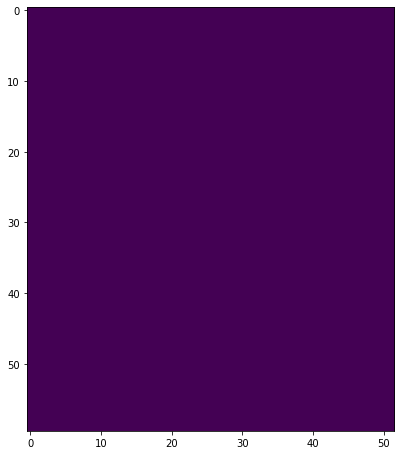

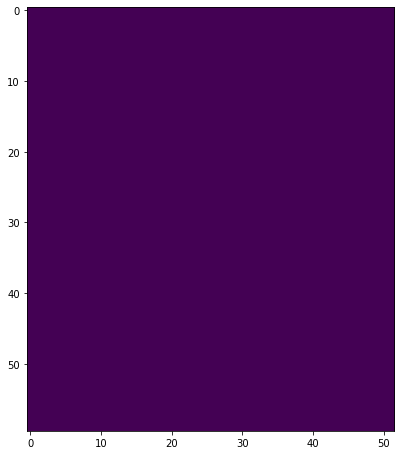

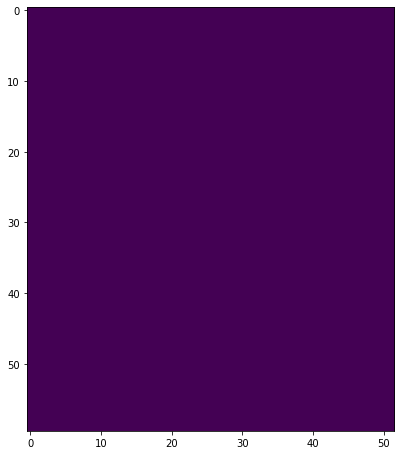

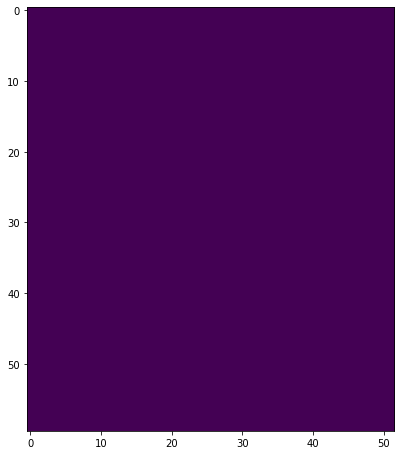

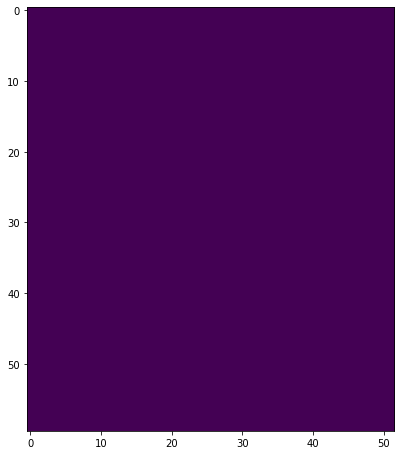

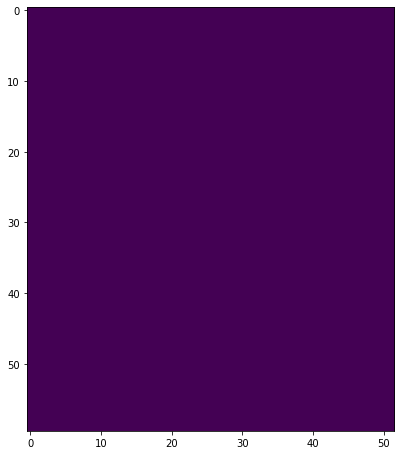

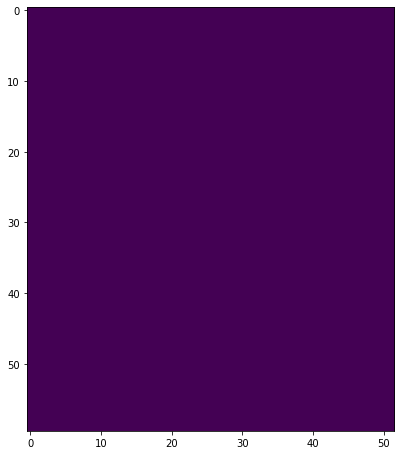

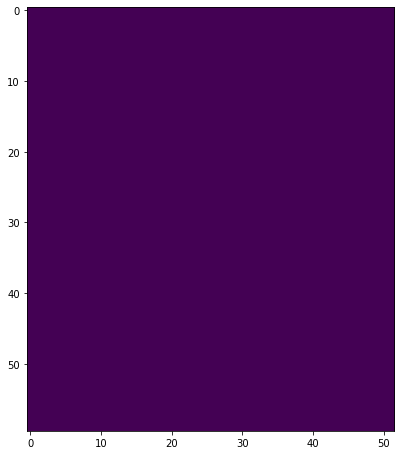

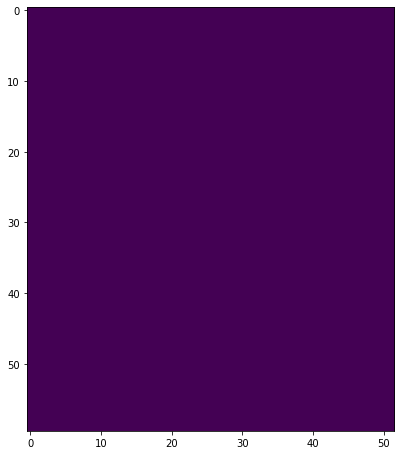

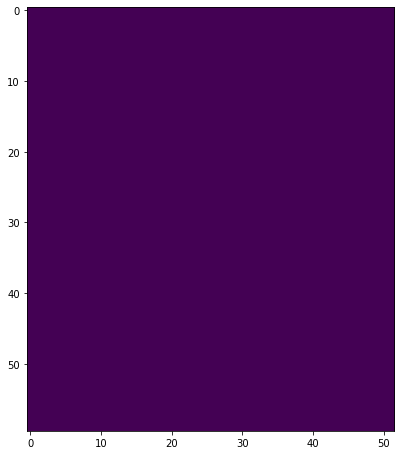

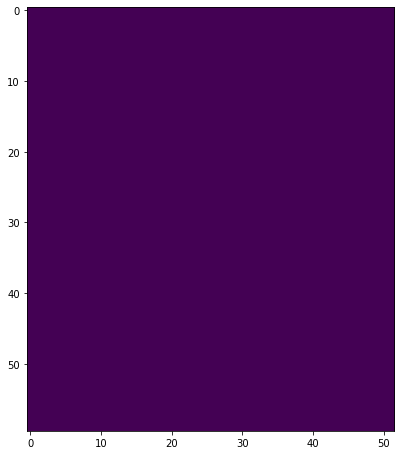

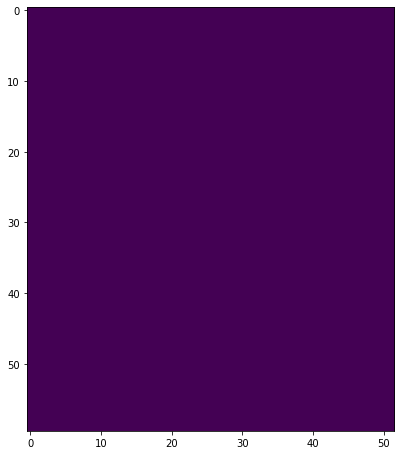

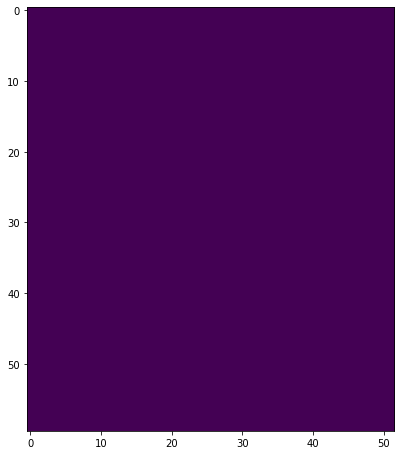

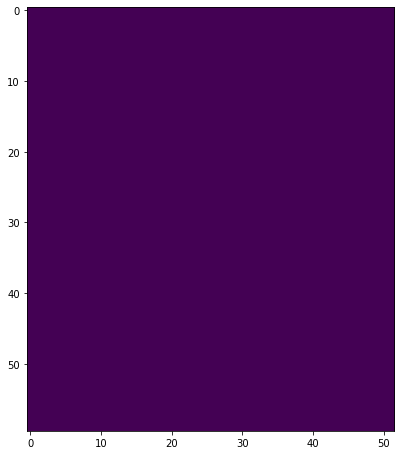

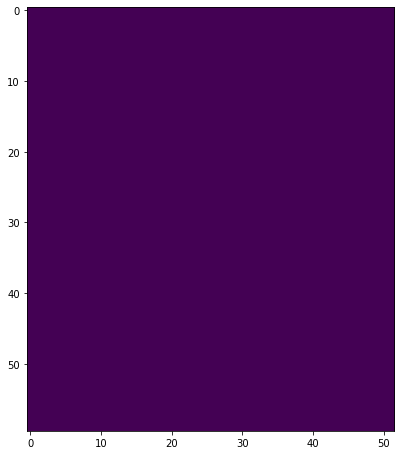

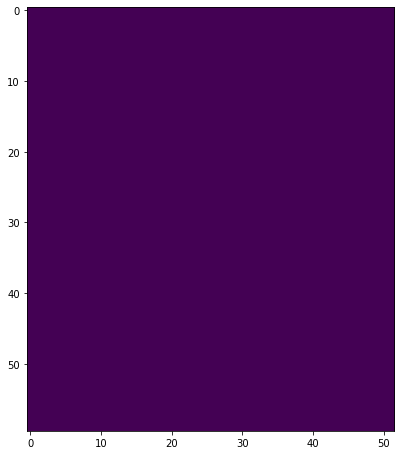

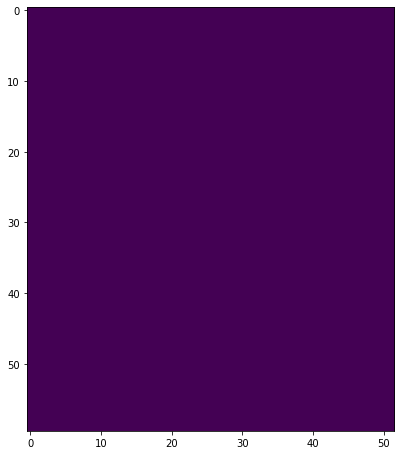

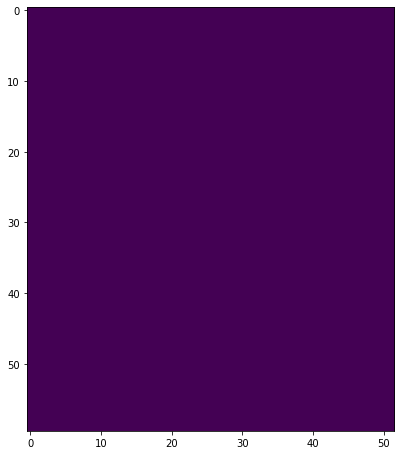

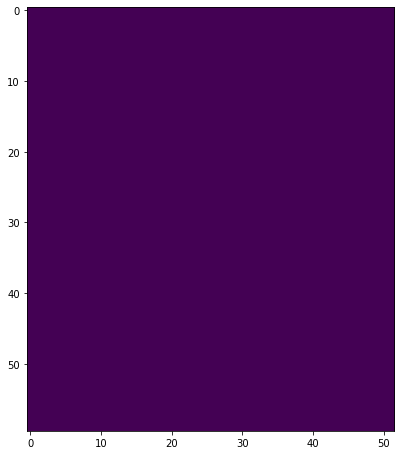

In [179]:
allregions = np.zeros((labels.shape[0],labels.shape[1])) 

for i in range(len(z)):
    
    r = (zws[i]*(z[i]>0))*(i+1)
    plt.imshow(r)
    allregions +=r
    plt.show()

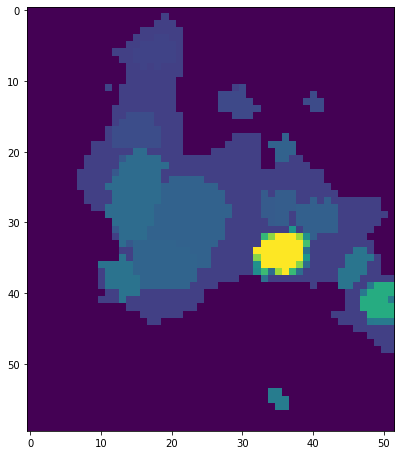

In [150]:
plt.imshow(allregions+(nonsat>0)*20)

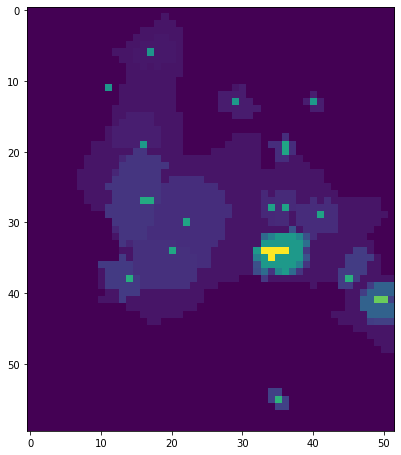

In [164]:
plt.imshow((allregions)+(nonsat>0)*10+seeds*10)

In [38]:
accum<1

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [89]:
1.25000000e+00

1.25